In [2]:
VAR = 'Psi'  # Pick what plot
Full = 'N'  # 9 Pannels isn't ideal for presentations N option give 4 plots
Year = 'PSI.nc'
# Load in Modules
from scipy.io import netcdf
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import sys
import glob
from scipy.interpolate import interp1d
from scipy import interpolate
from numba import autojit
from pylab import *
from matplotlib import gridspec
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
import useful as hb
import SG
%matplotlib inline
if Full == 'N':
    tau = ['3','Closed']
    # tau = ['3000']
else:
    tau = ['3', '10', '30', '100', '300',
           '1000', '3000', '10000', 'Closed']
Figletter = ['a) ','b) ','c) ','d) ']
# x = '/hpcdata/scratch/hb1g13/NchannelFlat'
x='/noc/msm/scratch/students/hb1g13/Mobilis'


# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()
# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r $^oC$ %'
else:
    fmt = '%r $^oC$'
# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'daynokpp/'+Year
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)


# Make Some useful functions
def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]


def regrid(Variable):
    Vc = (Variable[:, 0:-1]+Variable[:, 1::])/2
    return Vc
numba_regrid = autojit()(regrid)
numba_regrid.func_name = "numba_regrid"
Runs = np.array(runs)
# Set Parameters
alpha = 2.000000E-04
g = -9.81
rho_0 = 1000
C_p = 3985
gridfilepath = x+'/3daynokpp/'
file2 = netCDF4.Dataset(gridfilepath+'grid.nc', 'r')
Zp = file2.variables['Zp1'][:]
Z = file2.variables['Z'][:]
Y = file2.variables['Yp1'][:]
Yc = file2.variables['Y'][:]
dyc = file2.variables['dyC'][:]
dzc = file2.variables['drC'][:]
Zmatrix = np.zeros((len(Z), len(Yc)))
Zmatrix[:, :] = 1
dx = Y[1]-Y[0]  # Find Resolution
dz = Zp[0:len(Zp)-1]-Zp[1:len(Zp)]
Zmatrix[:,:] = np.apply_along_axis(np.multiply, 0, Zmatrix, dz)
DZ = np.apply_along_axis(np.multiply, 0, np.ones((len(Z),len(Yc))), Z)
ny = len(Y)
nz = len(Z)
Ly = 2000e3
Lx = 1000e3
H = Z[-1]
nx = np.round(Lx/dx)
ny = np.round(Ly/dx)
Q_0 = 10
Q = np.zeros_like(Yc)
pi = math.pi
Q = np.zeros(np.shape(Q))
Q[0:int(5*ny/36)] = Q_0*(np.cos(Yc[0:int(5*ny/36)]*(pi/(Yc[int(10*ny/36)]))))
Q[int(5*ny/36):int(20*ny/36)] = -Q_0*(np.sin((Yc[int(5*ny/36):int(20*ny/36)]-Yc[int(5*ny/36)])*(pi/(Yc[int(15*ny/36)]))))
Q[int(20*ny/36):int(30*ny/36)] = Q_0*(np.sin(Yc[0:int(10*ny/36)]*(pi/(Yc[int(10*ny/36)]))))
Psipred = -(Q)/(rho_0*C_p)

In [3]:
def ddy_cgrid_centered(y):
    dy = np.zeros(y.shape, np.float) #we know it will be this size
    h = Y[1] - Y[0] #this assumes the points are evenely spaced!
    dy[:,2:-2] = (y[:,0:-4] - 8 * y[:,1:-3] + 8 * y[:,3:-1] - y[:,4:]) / (12.0 * h)

    # simple differences at the end-points
    dy[:,0] = (y[:,1] - y[:,0])/(Y[1] - Y[0])
    dy[:,1] = (y[:,2] - y[:,1])/(Y[2] - Y[1])
    dy[:,-2] = (y[:,-2] - y[:,-3]) / (Y[-2] - Y[-3])
    dy[:,-1] = (y[:,-1] - y[:,-2]) / (Y[-1] - Y[-2])
    return dy

def ddz_cgrid_centered(y):
    dy = np.zeros(y.shape, np.float) 
    dy[0] = (y[0] - y[1])/(Z[0] - Z[1])
    for i in range(1,len(y)-1):
        dy[i] = (y[i+1] - y[i-1])/(Z[i+1]-Z[i-1])
    dy[-1] = (y[-1] - y[-2])/(Z[-1] - Z[-2])
    return dy

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def get_psi_iso_z(PSISO, Th):
    """Put the output from psi_iso into Z coordinates."""

    psi_iso = PSISO
    # figure out the depth of each layer
    h = Th
    # psi_iso is defined at the *bottom* of each layer,
    # therefore we want the depth at the bottom of the layer
    z = cumsum(h, axis=0) - (sum(th,axis=0))
    # interpolate to center z points
    psi_iso_z = zeros((nz+1,ny+1))
    for j in arange(ny):
        psi_iso_z[:,j] = interp(Zp[:],z[:,j], psi_iso[:,j])
    return psi_iso_z

\begin{equation}
    \int_{-H}^{0} \frac{\partial \Psi _{res}}{\partial y}\frac{\partial \overline{T}}{\partial z} + \frac{\partial \Psi _{res}}{\partial z}\frac{\partial \overline{T}}{\partial y} \mathrm{d}z = \frac{Q}{C_p \rho_0} + \int_{-H}^{0} \frac{\partial \overline{v'T'}-\frac{w'T'}{Sp}}{\partial y } \mathrm{d}z
\end{equation}

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:119: RuntimeWarning: divide by zero encountered in divide


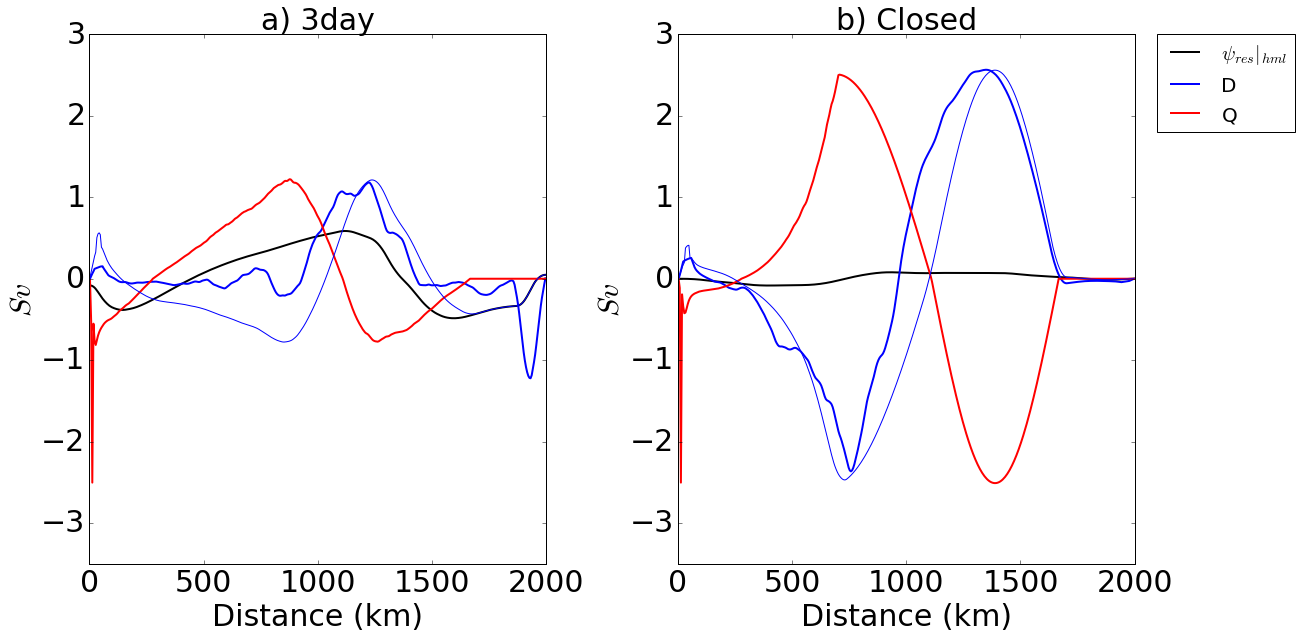

In [5]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    ax = fig.add_subplot(2, 2, i+1)
    
    # Psi_res(y,z)
    
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'+Year
    file2read = netCDF4.Dataset(fname, 'r')
    lvrho = file2read.variables["LaVH1TH"][:]
    th = file2read.variables["LaHs1TH"][:].mean(axis=3).mean(axis=0)
    dx = Y[1]-Y[0]  # Find Resolution
    VT = np.mean(lvrho, axis=3)  # Zonal average
    VTfdz = np.cumsum(VT[:, ::-1, :], axis=1)  # sum up the water column
    VTfdz = VTfdz
    # Time average and put into Sv and put back in right order
    psi = np.mean(VTfdz[:, ::-1, :], axis=0)
    psiz = hb.numba_regridz(hb.numba_regridy(get_psi_iso_z(psi, th)))
       
    # Temp field
    
    Rho = np.genfromtxt(x+'/'+str(tau[Runs[i]])+'daynokpp/Temp', delimiter=',')
    nolayers = len(psi[:, 1])
    Rho = Rho[0:nolayers]  # The layers package bins a layer so adjust
    Rho_matrix = np.apply_along_axis(np.multiply,0,ones_like(psi),Rho)
    T = hb.numba_regridz(hb.numba_regridy(get_psi_iso_z(Rho_matrix, th)))
    
    
    # Mean Stream Function:
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/Tav.nc'
    file2 = netCDF4.Dataset(fname, 'r')
    TTav = file2.variables['THETA'][:].mean(axis=0).mean(axis=2)
    VTav = file2.variables['VVEL'][:].mean(axis=0).mean(axis=2)
    WTav = file2.variables['WVEL'][:].mean(axis=0).mean(axis=2)
    npad =((0,1),(0,0))
    WTav = np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    ax = fig.add_subplot(2, 2, i+1)
    Eddy1 = x+'/'+str(tau[Runs[i]])+'daynokpp/Tav_VT.nc'
    f2 = netCDF4.Dataset(Eddy1,'r')
    VTTav = f2.variables['VVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = f2.variables['WVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = np.pad(WTTav,pad_width=npad, mode='constant', constant_values=0)
    VpTp = hb.numba_regridy(VTTav) - hb.numba_regridy(VTav)*TTav
    WpTp = hb.numba_regridz(WTTav) - hb.numba_regridz(WTav)*TTav
    Ty = ddy_cgrid_centered(TTav)
    Tz = ddz_cgrid_centered(TTav)
    VTy = hb.numba_regridy(VTav)*Ty
    WTz = hb.numba_regridz(WTav)*Tz
    WpTpz = ddz_cgrid_centered(WpTp)
    VpTpy = ddy_cgrid_centered(VpTp)
    Ty = ddy_cgrid_centered(TTav)
    Tz = ddz_cgrid_centered(TTav)
    VTy = hb.numba_regridy(VTav)*Ty
    WTz = hb.numba_regridz(WTav)*Tz
    WpTpz = ddz_cgrid_centered(WpTp)
    VpTpy = ddy_cgrid_centered(VpTp)
    Diff = np.nansum((VTy+WTz+WpTpz+VpTpy)*Zmatrix,axis=0)-Psipred
    
    Tavlat = TTav
    V = file2.variables["VVEL"][:]
    Vtave = np.mean(V, axis=0)
    Vtave[Vtave == 0] = np.nan
    Vzone = np.mean(Vtave, axis=2)
    # Got rid of for loop here (much quicker!!)
    psi2 = np.apply_along_axis(np.multiply, 0, Vzone, dz)
    psi = np.cumsum(-psi2[::-1, :], axis=0)
    npad = ((0, 1), (0, 0))
    # Pad with zeros at bottom
    psi = np.pad(psi, pad_width=npad, mode='constant',
                 constant_values=0)
    
    Psied = psiz - hb.numba_regridz(hb.numba_regridy(psi))
    

    # Depth?
    zz = 5 # Full
    
    # There's a little noise, don't let it add up
    # psiz[np.round(psiz,3)==0] = np.nan
    # int PyTz + PzTy dz
    Py = ddy_cgrid_centered(psiz)
    Pz = ddz_cgrid_centered(psiz)
    # Get rid of essentially 0
    Py[abs(np.round(psiz,2))+np.max(psiz)/5<=0.05] = 0
    Pz[abs(np.round(psiz,2))+np.max(psiz)/5<=0.05] = 0
    Py[isnan(psiz)] = 0
    Pz[isnan(psiz)] = 0
    # Use layers field
    Ty_l = ddy_cgrid_centered(T)
    Tz_l = ddz_cgrid_centered(T)
    Ty_l[isnan(Ty_l)] = 0
    Tz_l[isnan(Tz_l)] = 0
    ROC = psiz[3,:]
    # int dB/dZ dz = Q
    
    
    # Diabatic Eddy Flux
    # int dVT/dy - d(WT/Sp)/dy dz
    # Careful there are some crazy numbers appearing 
    # REMOVE NANS AND INFS
    
   
    Ty[Ty<10**-6] = 10**-6
    Tz[Tz<10**-6] = 10**-6
    Sp = -Ty/Tz
    Sp[isinf(Sp)]=0
    Sp[isnan(Sp)]=0
    AD = ddz_cgrid_centered(Psied)*Ty_l # Adiabatic eddies
    
    AD[isinf(AD)]=0
    AD[isnan(AD)]=0
    
    WTSpdy = ddy_cgrid_centered(AD)
    D = np.sum(((VpTpy-AD)*Zmatrix)[0:zz,:],axis=0)
    
    # Psied * Ty_l = W'T'
    
    WT = -Psied * Ty
    VT = Psied * Tz_l
    Sp_l = -Ty_l/Tz_l
    lvl = np.arange(-0.3,0.3,0.03)/50
    AD = WT/Sp
    D = ddy_cgrid_centered(VpTp-WT/Sp)/(Ty[0,:])
    
    D[8::] = 0
    
    Q = Psipred/Ty[0,:]
    
    D = -np.nansum((D*Zmatrix)[0:zz,0:400],axis =0)
    p = plt.plot(Yc/1000,SG.savitzky_golay(ROC,15,1),'k',linewidth=2)
    p = plt.plot(Yc/1000,SG.savitzky_golay(D,15,1),'b',linewidth=2)
    p = plt.plot(Yc/1000,Q,'r',linewidth=2)
    p = plt.plot(Yc/1000,SG.savitzky_golay(ROC-Q,15,1),'b',linewidth=1)
    plt.ylim(-3.5,3)

    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$Sv$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
lgd=plt.legend([r'$\psi_{res}|_{hml}$','D','Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:119: RuntimeWarning: divide by zero encountered in divide


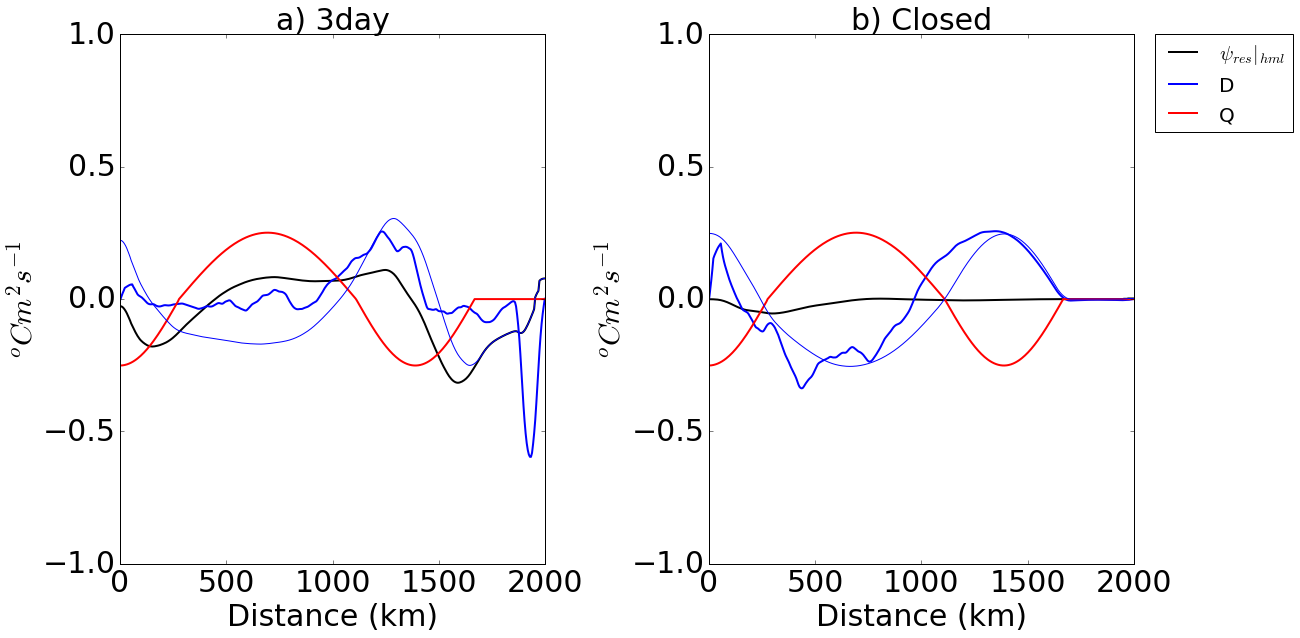

In [6]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    ax = fig.add_subplot(2, 2, i+1)
    
    # Psi_res(y,z)
    
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'+Year
    file2read = netCDF4.Dataset(fname, 'r')
    lvrho = file2read.variables["LaVH1TH"][:]
    th = file2read.variables["LaHs1TH"][:].mean(axis=3).mean(axis=0)
    dx = Y[1]-Y[0]  # Find Resolution
    VT = np.mean(lvrho, axis=3)  # Zonal average
    VTfdz = np.cumsum(VT[:, ::-1, :], axis=1)  # sum up the water column
    VTfdz = VTfdz
    # Time average and put into Sv and put back in right order
    psi = np.mean(VTfdz[:, ::-1, :], axis=0)
    psiz = hb.numba_regridz(hb.numba_regridy(get_psi_iso_z(psi, th)))
       
    # Temp field
    
    Rho = np.genfromtxt(x+'/'+str(tau[Runs[i]])+'daynokpp/Temp', delimiter=',')
    nolayers = len(psi[:, 1])
    Rho = Rho[0:nolayers]  # The layers package bins a layer so adjust
    Rho_matrix = np.apply_along_axis(np.multiply,0,ones_like(psi),Rho)
    T = hb.numba_regridz(hb.numba_regridy(get_psi_iso_z(Rho_matrix, th)))
    
    
    # Mean Stream Function:
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/Tav.nc'
    file2 = netCDF4.Dataset(fname, 'r')
    TTav = file2.variables['THETA'][:].mean(axis=0).mean(axis=2)
    VTav = file2.variables['VVEL'][:].mean(axis=0).mean(axis=2)
    WTav = file2.variables['WVEL'][:].mean(axis=0).mean(axis=2)
    npad =((0,1),(0,0))
    WTav = np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    ax = fig.add_subplot(2, 2, i+1)
    Eddy1 = x+'/'+str(tau[Runs[i]])+'daynokpp/Tav_VT.nc'
    f2 = netCDF4.Dataset(Eddy1,'r')
    VTTav = f2.variables['VVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = f2.variables['WVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = np.pad(WTTav,pad_width=npad, mode='constant', constant_values=0)
    VpTp = hb.numba_regridy(VTTav) - hb.numba_regridy(VTav)*TTav
    WpTp = hb.numba_regridz(WTTav) - hb.numba_regridz(WTav)*TTav
    Ty = ddy_cgrid_centered(TTav)
    Tz = ddz_cgrid_centered(TTav)
    VTy = hb.numba_regridy(VTav)*Ty
    WTz = hb.numba_regridz(WTav)*Tz
    WpTpz = ddz_cgrid_centered(WpTp)
    VpTpy = ddy_cgrid_centered(VpTp)
    Ty = ddy_cgrid_centered(TTav)
    Tz = ddz_cgrid_centered(TTav)
    VTy = hb.numba_regridy(VTav)*Ty
    WTz = hb.numba_regridz(WTav)*Tz
    WpTpz = ddz_cgrid_centered(WpTp)
    VpTpy = ddy_cgrid_centered(VpTp)
    Diff = np.nansum((VTy+WTz+WpTpz+VpTpy)*Zmatrix,axis=0)-Psipred
    
    Tavlat = TTav
    V = file2.variables["VVEL"][:]
    Vtave = np.mean(V, axis=0)
    Vtave[Vtave == 0] = np.nan
    Vzone = np.mean(Vtave, axis=2)
    # Got rid of for loop here (much quicker!!)
    psi2 = np.apply_along_axis(np.multiply, 0, Vzone, dz)
    psi = np.cumsum(-psi2[::-1, :], axis=0)
    npad = ((0, 1), (0, 0))
    # Pad with zeros at bottom
    psi = np.pad(psi, pad_width=npad, mode='constant',
                 constant_values=0)
    
    Psied = psiz - hb.numba_regridz(hb.numba_regridy(psi))
    

    # Depth?
    zz = 5 # Full
    
    # There's a little noise, don't let it add up
    # psiz[np.round(psiz,3)==0] = np.nan
    # int PyTz + PzTy dz
    Py = ddy_cgrid_centered(psiz)
    Pz = ddz_cgrid_centered(psiz)
    # Get rid of essentially 0
    Py[abs(np.round(psiz,2))+np.max(psiz)/5<=0.05] = 0
    Pz[abs(np.round(psiz,2))+np.max(psiz)/5<=0.05] = 0
    Py[isnan(psiz)] = 0
    Pz[isnan(psiz)] = 0
    # Use layers field
    Ty_l = ddy_cgrid_centered(T)
    Tz_l = ddz_cgrid_centered(T)
    Ty_l[isnan(Ty_l)] = 0
    Tz_l[isnan(Tz_l)] = 0
    ROC = psiz[3,:]*Ty[0,:]
    # int dB/dZ dz = Q
    
    
    # Diabatic Eddy Flux
    # int dVT/dy - d(WT/Sp)/dy dz
    # Careful there are some crazy numbers appearing 
    # REMOVE NANS AND INFS
    
   
    Ty[Ty<10**-6] = 10**-6
    Tz[Tz<10**-6] = 10**-6
    Sp = -Ty/Tz
    Sp[isinf(Sp)]=0
    Sp[isnan(Sp)]=0
    AD = ddz_cgrid_centered(Psied)*Ty_l # Adiabatic eddies
    
    AD[isinf(AD)]=0
    AD[isnan(AD)]=0
    
    WTSpdy = ddy_cgrid_centered(AD)
    D = np.sum(((VpTpy-AD)*Zmatrix)[0:zz,:],axis=0)
    
    # Psied * Ty_l = W'T'
    
    WT = -Psied * Ty
    VT = Psied * Tz_l
    Sp_l = -Ty_l/Tz_l
    lvl = np.arange(-0.3,0.3,0.03)/50
    AD = WT/Sp
    D = ddy_cgrid_centered(VpTp-WT/Sp)
    
    D[8::] = 0
    
    Q = Psipred
    
    D = -np.nansum((D*Zmatrix)[0:zz,0:400],axis =0)
    p = plt.plot(Yc/1000,SG.savitzky_golay(ROC*10**5,15,1),'k',linewidth=2)
    p = plt.plot(Yc/1000,SG.savitzky_golay(D*10**5,15,1),'b',linewidth=2)
    p = plt.plot(Yc/1000,Q*10**5,'r',linewidth=2)
    p = plt.plot(Yc/1000,SG.savitzky_golay((ROC-Q)*10**5,15,1),'b',linewidth=1)
    plt.ylim(-1,1)

    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oC m^2 s^{-1} $', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
lgd=plt.legend([r'$\psi_{res}|_{hml}$','D','Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)